# 5. Encoder-decoder embedding

In this notebook, we will train a model with the best hyperparameters found using `Ax` from notebook 4 and save this.

We will also take a look at the learnt embeddings.

In [1]:
# allows for import from `src` directory
import sys 
sys.path.append('../')

from src import data
from src import utils

from models.encoder_decoder_dropout import *

## 5.1 Set up data

In [2]:
# fixed data parameters
data_params = {
    'n_input_steps': 48,
    'n_output_steps': 12
}

# run the data preprocessing pipeline to create dataset
df, _, samples = data.pipeline(data_params['n_input_steps'], data_params['n_output_steps'], '../data')
datasets = data.get_datasets(samples, data_params['n_input_steps'])


Data already downloaded

43910 train rows from 2012-10-02 09:00:00 to 2017-10-05 23:00:00
4320 valid rows from 2017-10-05 23:00:00 to 2018-04-03 23:00:00
4321 test rows from 2018-04-03 23:00:00 to 2018-09-30 23:00:00

16625 samples of 48 input steps and 12 output steps in train
3534 samples of 48 input steps and 12 output steps in valid
4020 samples of 48 input steps and 12 output steps in test



## 5.2 Train model with best hyperparameters

In [3]:
device = utils.get_device()
print(device)

cuda:0


In [4]:
params = {
    'num_epochs': 192,
    'learning_rate': 0.0005753955111014699,
    'batch_size': 292,
    'variational_dropout_p': 0.24793713575125884
}

dataloaders = data.get_dataloaders(datasets, params.get('batch_size'))
in_features = dataloaders['train'].dataset.X.shape[-1]
model = VDEncoderDecoder(in_features=in_features,
                         input_steps=params.get('n_input_steps', 48),
                         output_steps=params.get('n_output_steps', 12),
                         p=params.get('variational_dropout_p')
                        )

model,losses = utils.train(device=device, model=model, 
                           dataloader=dataloaders['train'], 
                           params=params, use_tqdm=True, 
                           validate=dataloaders['valid'])


Epoch=191 | [16625|16625]	train. loss=0.7511	valid. loss=0.2013: 100%|██████████| 192/192 [05:42<00:00,  1.78s/it]


### Plot losses

Text(0.5, 1.0, 'MSE Loss')

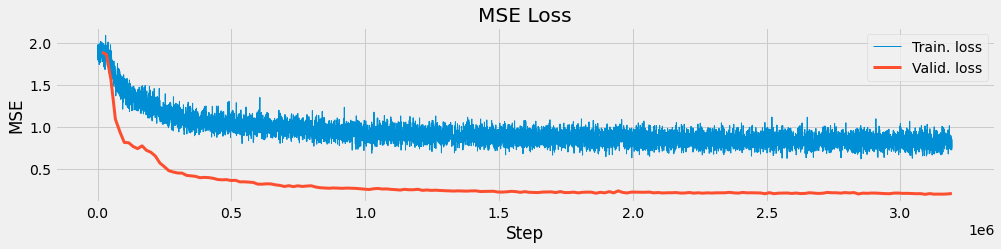

In [49]:
from matplotlib import pyplot as plt
import numpy as np
plt.style.use('fivethirtyeight')

fig,axs = plt.subplots(1,1,figsize=(15,3))
axs.plot(*np.vstack(losses['train']).T, lw=1, label='Train. loss')
axs.plot(*np.vstack(losses['valid']).T, lw=3, label='Valid. loss')
axs.legend(loc='best')
axs.set_xlabel('Step')
axs.set_ylabel('MSE')
axs.set_title('MSE Loss')

### Save trained pretraining model

In [10]:
from pathlib import Path
def save(model: nn.Module, name: str, path: str='../model_artifacts'):
    Path(path).mkdir(parents=True, exist_ok=True)
    torch.save(model, f'{path}/{name}.pt')

save(model, name='pretraining', path='../model_artifacts')

## 5.3 Explore the embedding

### Use validation data

In [11]:
for x,y in dataloaders['valid']:
    break

### Run data through the encoder part of the model

In [12]:
embeddings = model.model['encoder'](x.to(device))
embeddings = embeddings.cpu().detach().numpy().reshape(-1,48)

### Reduce the 48 dimensional vectors with PCA

In [13]:
def pca_fit(data, normalise=True):
    from sklearn.decomposition import PCA

    if normalise: 
        mu,std = np.mean(data, axis=0), np.std(data, axis=0)
        data = (data - mu) / std

    pca = PCA()

    return pca.fit_transform(data)
pca = pca_fit(embeddings, normalise=False)

### Plot the 2 principal components

In [19]:
import matplotlib.cm as cm
from matplotlib.colors import Normalize

# dict[column name]: int column index 
cols = {col:c for c,col in enumerate(df.columns)}

def get_cmap_colours(col, column_data, cmap=cm.viridis):
    norm = Normalize(vmin=column_data.min(), 
                     vmax=column_data.max())

    colours = [cmap(norm(i)) for i in x.numpy()[:,-1,cols[col]]]

    return colours

col = 'hour_sin'
cmap = cm.viridis

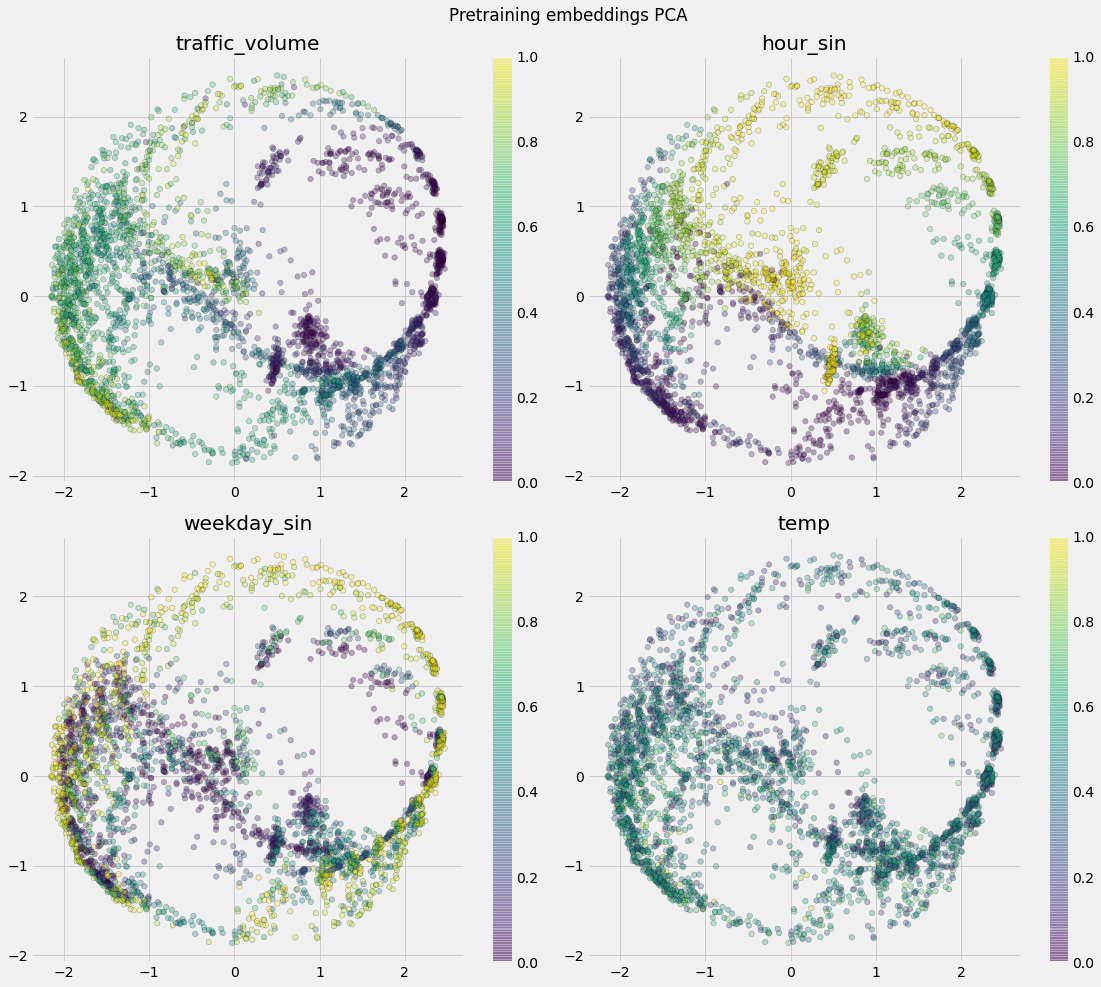

In [46]:
fig, axs = plt.subplots(2,2,figsize=(16,14))

for col,ax in zip(['traffic_volume', 'hour_sin', 'weekday_sin','temp'],np.hstack(axs)):
    column_data = x.numpy()[:,-1,cols[col]]
    colours = get_cmap_colours(col, column_data, cmap)
    cm = ax.scatter(*pca[:,[0,1]].T, c=colours, alpha=1/3, s=30,  cmap=cmap, edgecolors='k')
    plt.colorbar(cm,ax=ax)
    ax.set_title(col)
fig.suptitle('Pretraining embeddings PCA')
plt.tight_layout()

## 5.4 Make predictions with the pretrained encoder-decoder

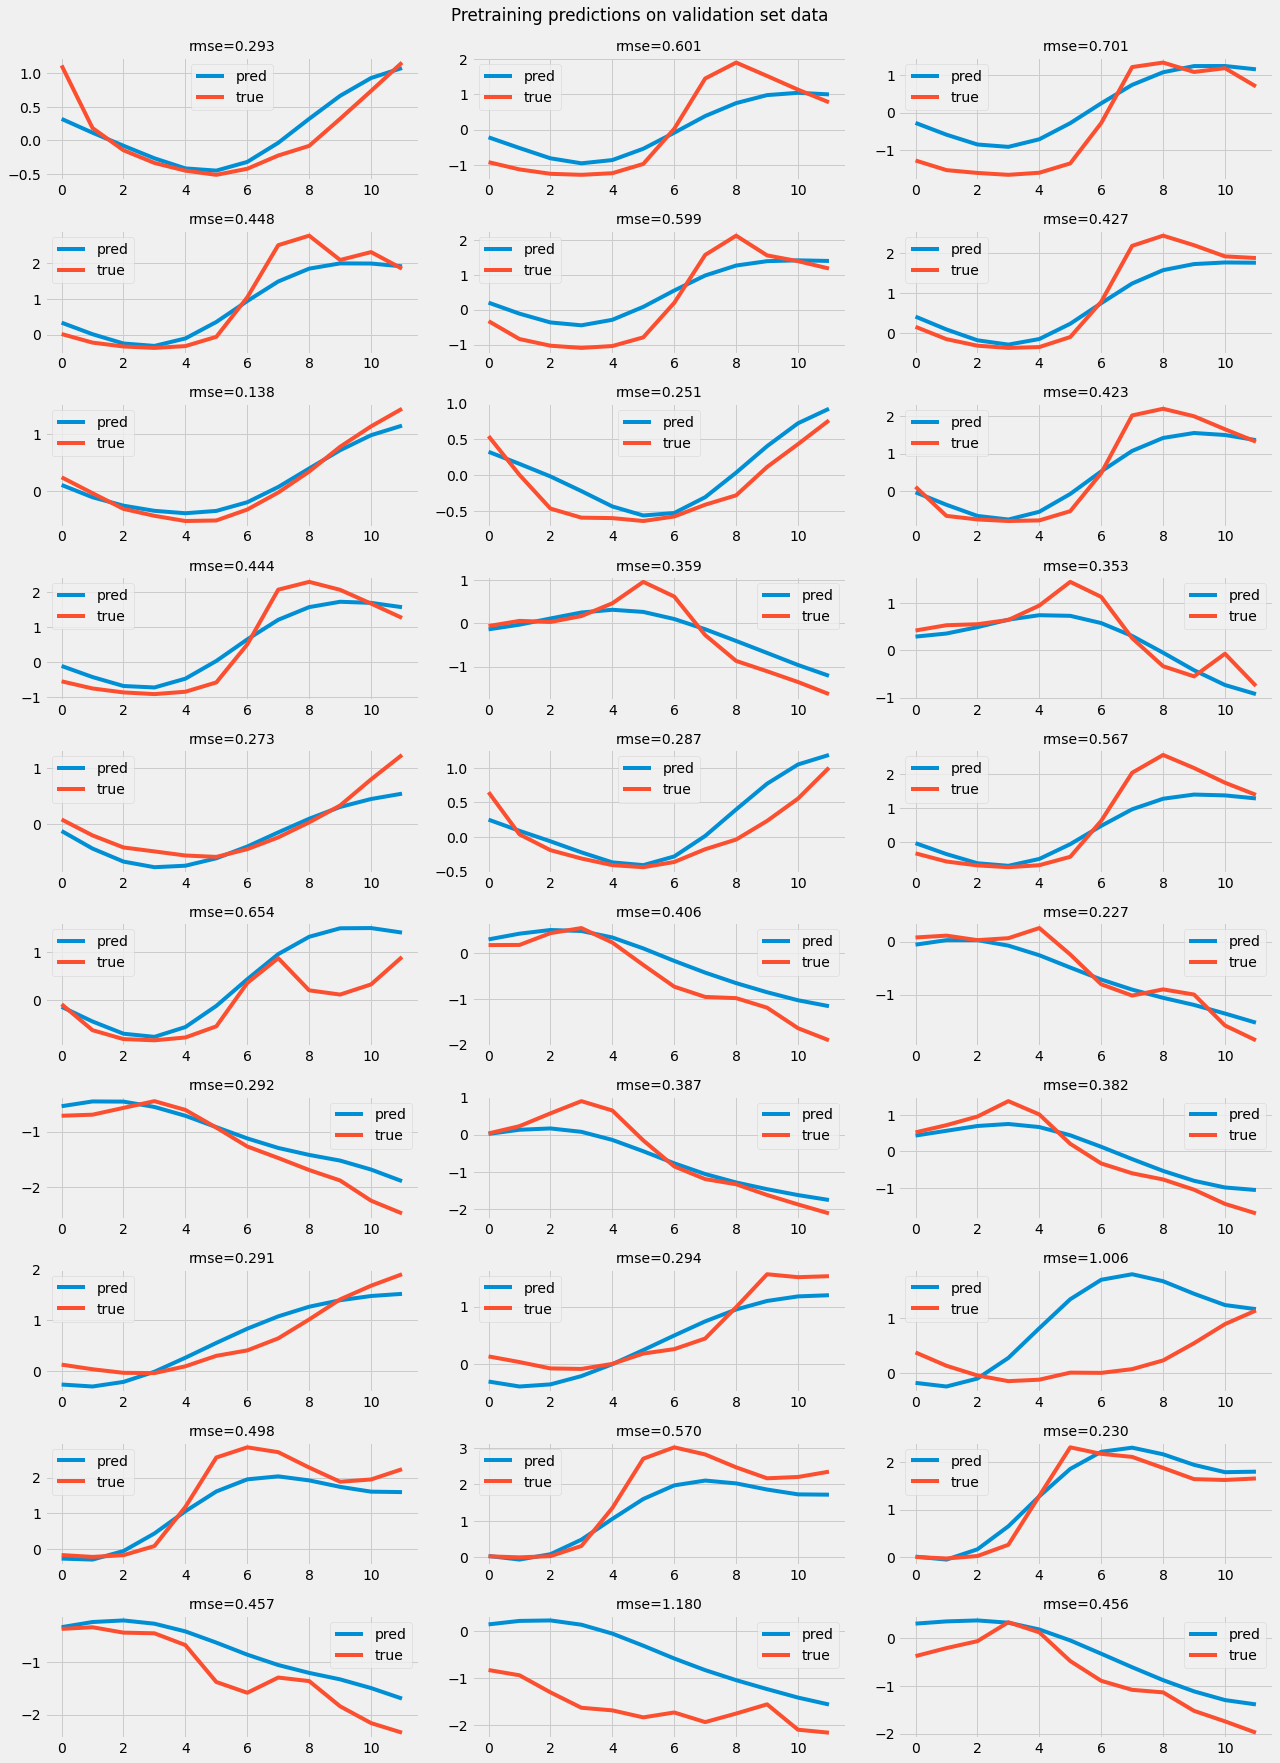

In [48]:
for x,y in dataloaders['valid']:
    break

y_pred = model(x.to(device)).cpu().detach().numpy()[::24]
y = y[::24]

n_rows, n_cols = 10,3
fig,axs = plt.subplots(n_rows, n_cols,figsize=(6*n_cols, 2.5*n_rows))
for r in range(n_rows):
    for c in range(n_cols):
        i = r*n_rows+c
        axs[r][c].plot(y_pred[i],label='pred')
        axs[r][c].plot(y[i,:].numpy(),label='true')
        axs[r][c].legend()
        rmse = np.sqrt(np.mean((y_pred[i] - y[i,:].numpy())**2))
        axs[r][c].set_title('rmse={0:.3f}'.format(rmse),fontsize=14)
fig.suptitle('Pretraining predictions on validation set data\n')
plt.tight_layout()